# User engagement and churn analysis

This project analyses the user behaviour and churn using data provided by Revolut. The data is split into 4 different data files: 

**devices.csv** - a table of devices associated with a user

**users.csv** - a table regarding user information 

**notifications.csv** - a table regarding notifications that are beeing sent to users.

**transactions.csv** - a table containing transaction data of users. 

All the tables can be joined together by the id variable **user_id**.

The programming language used is **Python 3.7**

# Engagement definition

A user can be called **engaged** when the user, given a certain period of time, interacts with a product. In Revolut's case, this would mean that a user interacts with any of the features that Revolut provides: checks his cyber wallet, sends money, uses Revolut's credit card, etc. 

Increasing user engagement is a top priority for most of companies, both in retail and in digital. Generally, by increasing the number of times a user interacts or uses a certain product, companies increase their revenue. For example, the more transactions the users make via the Revolut system, the more revenue is beeing generated from fee and from foreign exchange spreads. 

Additionally, knowing which users are engaged is very beneficial when designing a marketing or pricing strategy. Depending on the marketing goal, promotional money could be allocated between engaged users, disengaged users or aquirying new users.

A signed-on user who has not engaged in anything related to Revolut for a long period of time could be called **disengaged** or **churned**. 

*This project will try to quantify and establish a definition of when a user can be called a churned user using data.*

*Additionally, when the definition is defined, we will try to model and predict whether a user will churn or not.*

# Loading python packages

In [1]:
# Data wrangling
import pandas as pd 

# Visualizations
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Working with dates
import datetime

# Array math 
import numpy as np

# Data cleaning functions
from data_cleaning import convert_time, dollar_band, dollar_band_middle_point

# Feature engineering class for the transaction data
from feature_engineering import TransactionFeatures

# K fold analysis package
from sklearn.model_selection import KFold

# Logistic regression package
from sklearn.linear_model import LogisticRegression

# Precision score accuracy measure
from sklearn.metrics import accuracy_score

# Neural networks packages
from xgboost import XGBClassifier

# Explanatory data analysis (EDA) of input data

## Reading the data with pandas 

In [2]:
devices = pd.read_csv('data/rev-devices.csv')
users = pd.read_csv('data/rev-users.csv')
notifications = pd.read_csv('data/rev-notifications.csv')
transactions = pd.read_csv('data/rev-transactions.csv')

## Users 

Everytime a new user downloads, installs and registers on the Revolut application a new row is created in the Users table. 

In [3]:
users.head()

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0
2,user_2,1987,PL,Poznań,2018-01-18 19:17:31.229096,0,STANDARD,0.0,0.0,21,0,0
3,user_3,1994,FR,Paris,2018-01-15 18:47:56.723104,0,STANDARD,1.0,0.0,0,0,0
4,user_4,1985,GB,Beckenham,2018-01-11 00:36:46.673673,0,STANDARD,NaN,NaN,2,0,0


In [4]:
users.shape

(19430, 12)

In [5]:
len(set(users['user_id']))

19430

The number of rows and in the **users** data and the number of unique **user_id**s is the same meaning that one user has one unique row in the dataset. There are **19430** unique users in this dataset.

In [6]:
# Converting the created_date column from string to a datetime object
users['created_date'] = [convert_time(x) for x in users['created_date']] 

# Renaming the column to account_created_date for further use 
users = users.rename(columns={'created_date': 'account_created_date'})

# Calculating the user age at the time of sign in 
users['age_at_signin'] = [x.year for x in users['account_created_date']] - users['birth_year']

# Calculating the current user age
users['current_user_age'] = [datetime.datetime.now().year - x for x in users['birth_year']]

# Calculating years with Revolut
users['years_with_revolut'] = users['current_user_age'] - users['age_at_signin']

In [7]:
print(f"""
    The first sign in date: {min(users['account_created_date']).date().strftime('%Y-%m-%d')}
    The last sign in date: {max(users['account_created_date']).date().strftime('%Y-%m-%d')} 
     """)


    The first sign in date: 2018-01-01
    The last sign in date: 2019-01-03 
     


The users in the data provided are from the period **2018-01-01** through **2019-01-03**. 

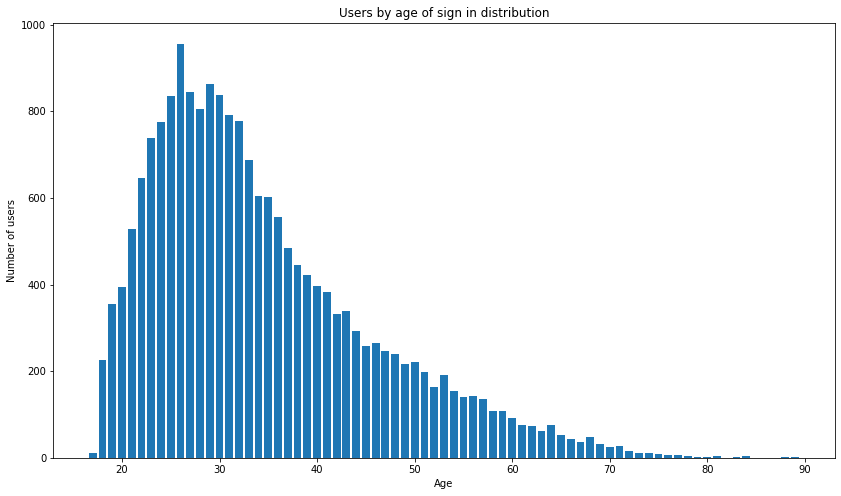

In [8]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age
grouped = users.groupby(['age_at_signin'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
plt.bar(x=grouped['age_at_signin'], height=grouped['user_count'])
plt.title('Users by age of sign in distribution')
plt.xlabel('Age')
plt.ylabel('Number of users')
plt.show()

The distribution of the user age is a right skewed distribution with the biggest number of users beeing between the year 25 and 35. 

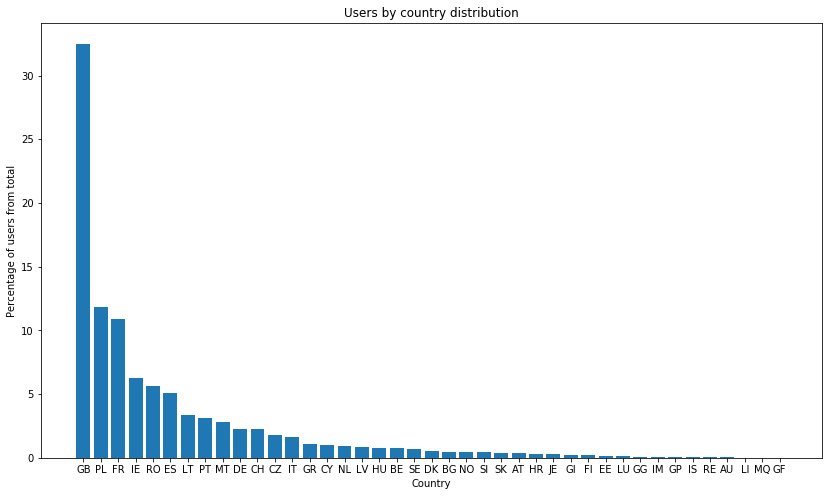

In [9]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age

# Calculating the share of all users by country
grouped = users.groupby(['country'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
grouped.sort_values('user_count', inplace=True, ascending=False)
grouped['share'] = grouped['user_count'] * 100/np.sum(grouped['user_count'])

plt.bar(x=grouped['country'], height=grouped['share'])
plt.title('Users by country distribution')
plt.xlabel('Country')
plt.ylabel('Percentage of users from total')
plt.show()

The vast majority of the users are from Great Britain (GB), Poland (PL) and France (FR). They amount to more than **50 percent** of all the users.

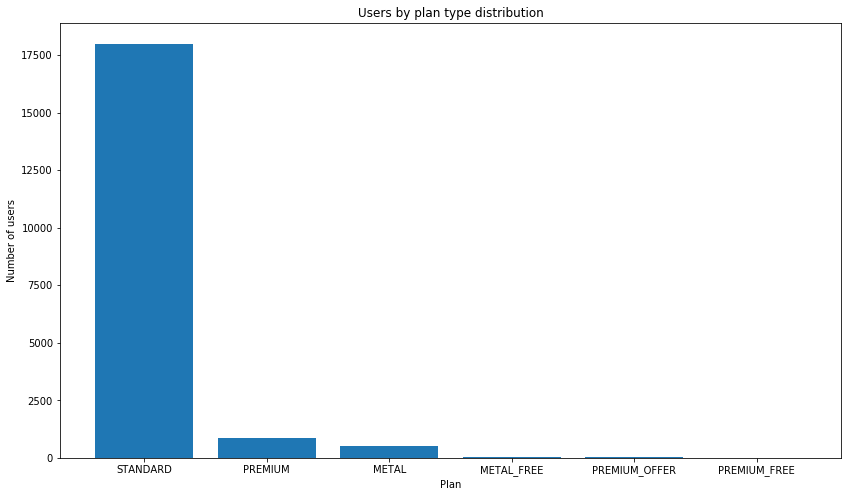

In [10]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age

# Calculating the share of all users by country
grouped = users.groupby(['plan'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
grouped.sort_values('user_count', inplace=True, ascending=False)

plt.bar(x=grouped['plan'], height=grouped['user_count'])
plt.title('Users by plan type distribution')
plt.xlabel('Plan')
plt.ylabel('Number of users')
plt.show()

The vast majority of the users in the dataset have a STANDART plan.

## Devices 

The information in the devices data represent what operating system does a user use. This is deducted by the type of the application version that a user downloads and installs.

In [11]:
devices.head()

,brand,user_id
0,Android,user_3257
1,Apple,user_6809
2,Android,user_9144
3,Apple,user_3636
4,Android,user_5970


In [12]:
devices.shape

(19430, 2)

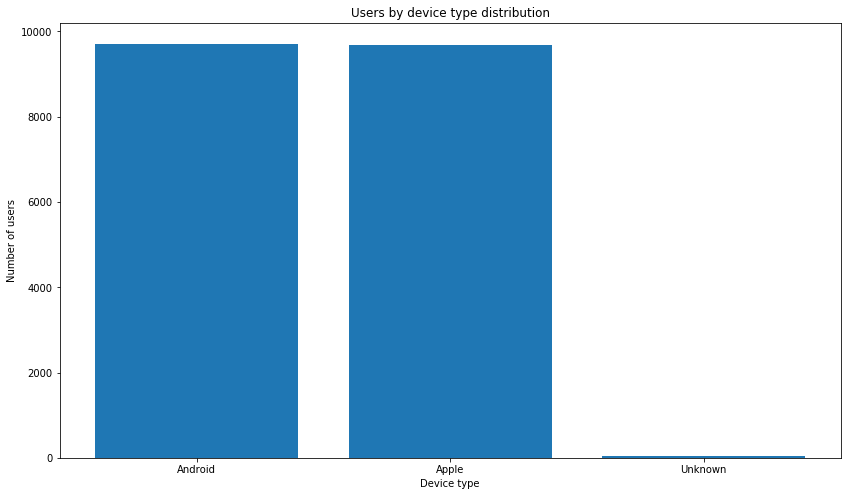

In [13]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age
grouped = devices.groupby(['brand'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
plt.bar(x=grouped['brand'], height=grouped['user_count'])
plt.title('Users by device type distribution')
plt.xlabel('Device type')
plt.ylabel('Number of users')
plt.show()

The total majority of the users use either android or apple devices. The distribution between these two systems is almost identical in terms of user count.

We can deduct that all the users in this dataset are mobile Revolut users. 

## Notifications 

Revolut sends various notifications to users. Every notifications has a reason and a channel indicating how a user was notified. 

In [14]:
# Converting created_date column
notifications['created_date'] = [convert_time(x) for x in notifications['created_date']]

# Head of data
notifications.head()

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127
2,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_4151,2018-12-04 02:57:56.425660
3,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_1408,2018-12-11 02:04:46.284683
4,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6292,2018-12-14 17:09:58.900808


The reasons can be various: notifications about insufficient funds, information about bill splitting in restaurants, public holidays, etc. 

Unique reasons:

In [15]:
set(notifications['reason'])

{'BLACK_FRIDAY',
 'ENGAGEMENT_SPLIT_BILL_RESTAURANT',
 'FIFTH_PAYMENT_PROMO',
 'JOINING_ANNIVERSARY',
 'LOST_CARD_ORDER',
 'MADE_MONEY_REQUEST_NOT_SPLIT_BILL',
 'METAL_GAME_START',
 'METAL_RESERVE_PLAN',
 'NO_INITIAL_CARD_ORDER',
 'NO_INITIAL_CARD_USE',
 'NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER',
 'ONBOARDING_TIPS_ACTIVATED_USERS',
 'PREMIUM_ENGAGEMENT_FEES_SAVED',
 'PREMIUM_ENGAGEMENT_INACTIVE_CARD',
 'PUMPKIN_PAYMENT_NOTIFICATION',
 'REENGAGEMENT_ACTIVE_FUNDS',
 'WELCOME_HOME'}

Unique channels: 

In [16]:
set(notifications['channel'])

{'EMAIL', 'PUSH', 'SMS'}

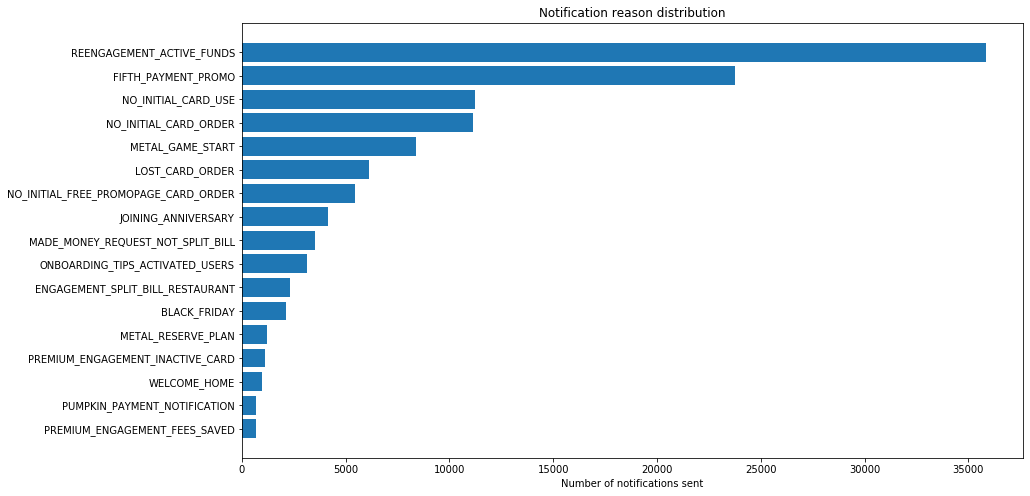

In [17]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age
grouped = notifications.groupby(['reason'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
grouped.sort_values('user_count', inplace=True)
plt.barh(y=grouped['reason'], width=grouped['user_count'])
plt.title('Notification reason distribution')
plt.xlabel('Number of notifications sent')
plt.show()

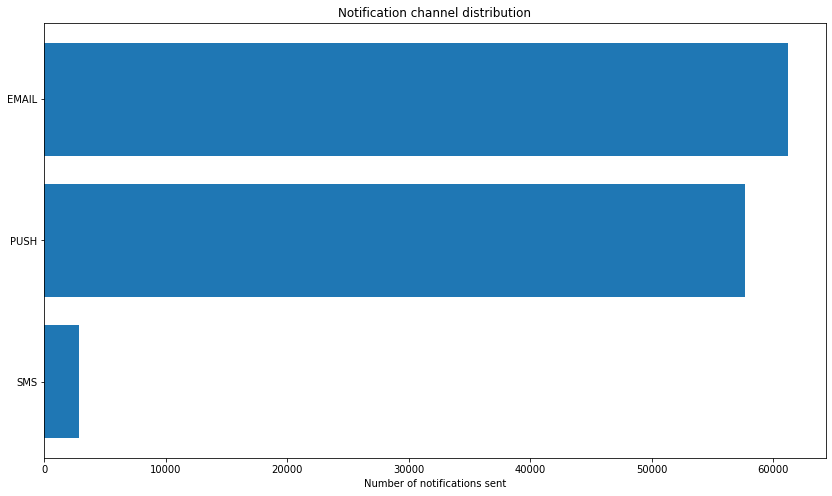

In [18]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age
grouped = notifications.groupby(['channel'], as_index=False)['user_id'].count().rename(columns={'user_id':'user_count'})
grouped.sort_values('user_count', inplace=True)
plt.barh(y=grouped['channel'], width=grouped['user_count'])
plt.title('Notification channel distribution')
plt.xlabel('Number of notifications sent')
plt.show()

As we can see, the two biggest reasons for notifications are **reengagement_active_funds** and **fifth_payment_promo**. The channels by which these notifications are beeing sent are either email or push notifications that pop up on the user screen.

In [19]:
# Creating a notification sent date 
notifications['sent_day'] = [x.date() for x in notifications['created_date']]

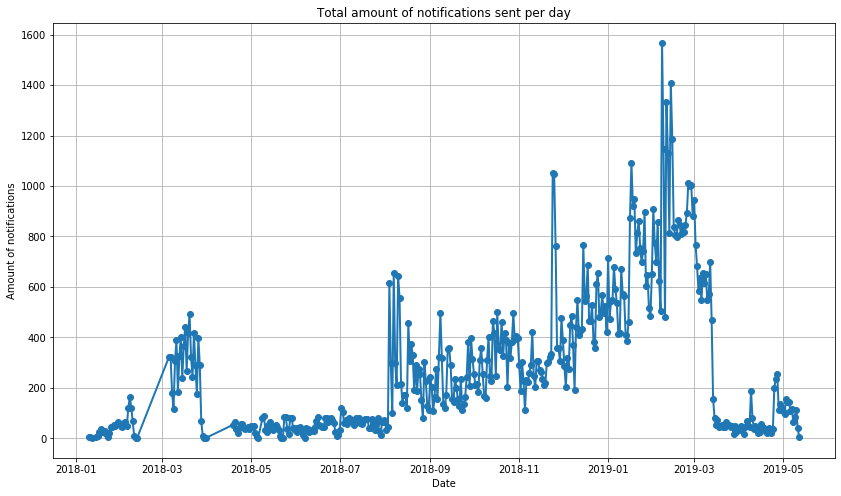

In [20]:
# Creating a time series
ts_notify = notifications.groupby(['sent_day'], as_index=False)['user_id'].count().rename(columns={'user_id':'notify_count'})

# Ploting
plt.figure(figsize=(14, 8))
plt.plot('sent_day', 'notify_count', '-o', data=ts_notify, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Amount of notifications')
plt.title('Total amount of notifications sent per day')
plt.grid()
plt.show()

There was a steady increase in notifications from 2018-09 up until 2019-09. The sudden drop from that date may indicate a change in marketing strategy.

## Transactions 

An event where a user sends money from his account is called a transaction. Every unique transaction creates a new row in the **transactions** table. All the transactions, no matter if the currency is USD or not, have a column indicating the transacting amount in USD. 

In [21]:
transactions.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


In [22]:
transactions.shape

(2740075, 12)

There are more than 2.5 million unique transactions om the dataset.

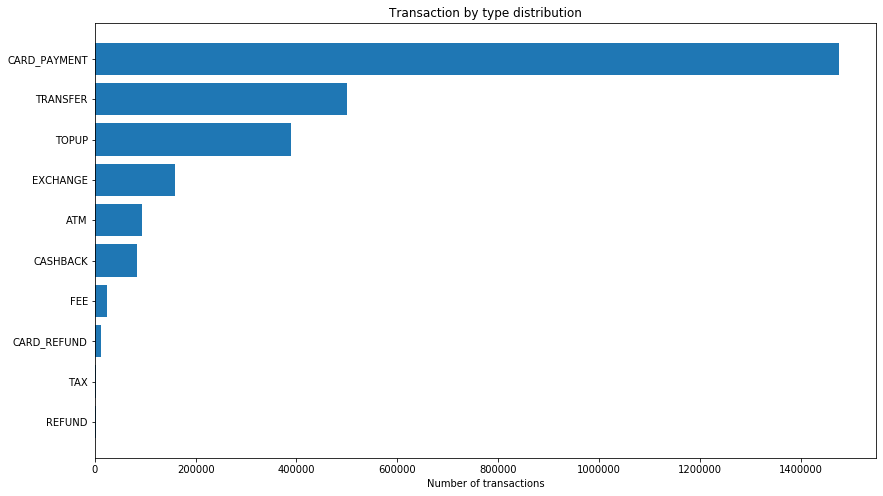

In [23]:
plt.figure(figsize=(14, 8))

# Ploting the distribution by sign in age
grouped = transactions.groupby(['transactions_type'], as_index=False)['user_id'].count().rename(columns={'user_id':'txn_count'})
grouped.sort_values('txn_count', inplace=True)
plt.barh(y=grouped['transactions_type'], width=grouped['txn_count'])
plt.title('Transaction by type distribution')
plt.xlabel('Number of transactions')
plt.show()

The most popular type by far is the card payment type. Every time a user uses his Revolut card, the counter of total transactions by card is increased by one. The second most popular payment type is the transfer method, where a user sends money from one revolut account to another. 

In [24]:
# Converting the created_date column to datetime 
transactions['created_date'] = [convert_time(x) for x in transactions['created_date']]

# Creating the day column 
transactions['transaction_day'] = [x.date() for x in transactions['created_date']]

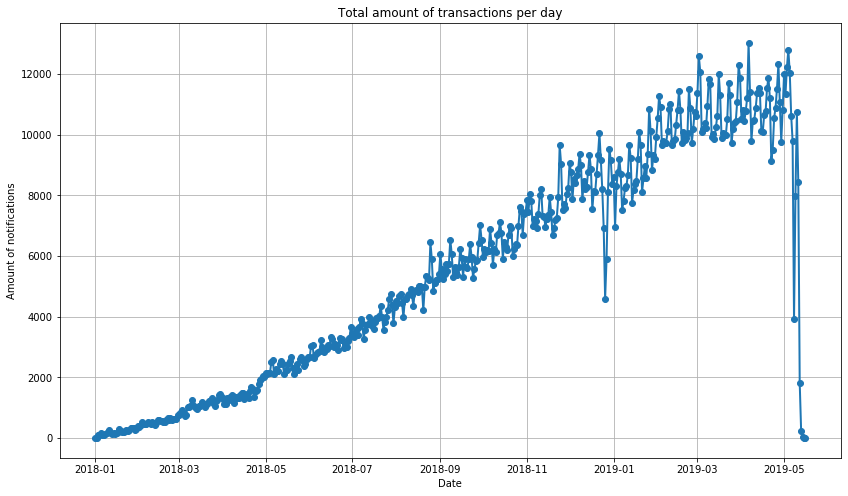

In [25]:
# Creating a time series
ts_txn = transactions.groupby(['transaction_day'], as_index=False)['user_id'].count().rename(columns={'user_id':'transaction_count'})

# Ploting
plt.figure(figsize=(14, 8))
plt.plot('transaction_day', 'transaction_count', '-o', data=ts_txn, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Amount of notifications')
plt.title('Total amount of transactions per day')
plt.grid()
plt.show()

Probably because of the data extraction process, the last days in the data set have a huge drop in total number of transactions.

In [26]:
# Creating the dollar band column 
transactions['dollar_band'] = [dollar_band(x) for x in transactions['amount_usd']]

# Creating the middle point of dollar band 
transactions['middle_point'] = [dollar_band_middle_point(x) for x in transactions['dollar_band']]

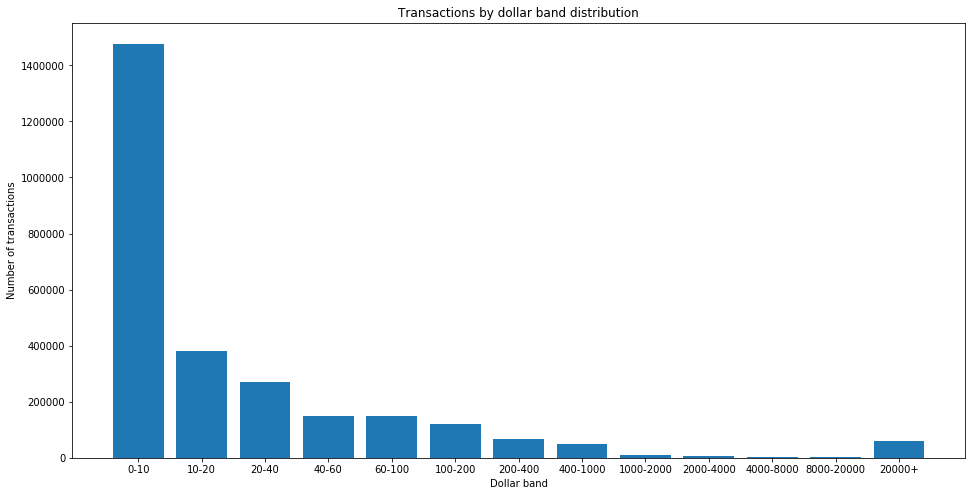

In [27]:
# Visualizing the count of transaction by amount sent
plt.figure(figsize=(16, 8))

# Ploting the distribution by sign in age

# Calculating the share of all users by country
grouped = transactions.groupby(['dollar_band', 'middle_point'], as_index=False)['user_id'].count().rename(columns={'user_id':'txn_count'})
grouped.sort_values('middle_point', inplace=True)

plt.bar(x=grouped['dollar_band'], height=grouped['txn_count'])
plt.title('Transactions by dollar band distribution')
plt.xlabel('Dollar band')
plt.ylabel('Number of transactions')
plt.show()

As we can see, the vast majority of the transactions are ranging between 0 and 10 dollars. Taking into account that the biggest number of transaction type is card payments, we can conclude that **most users in our data set use Revolut for small payments using the revolut card**.

# EDA of user behaviour and defining a disengaged user

In order to determine which users are disengaged or not we need to see the historical trends of user daily behaviour. We will analyze how the average number of transactions changes over time since installation and how do users behave in terms of transaction frequency.

## Average transactions per user since installation

We need to analyze whether user behaviour changes over time since installation of the Revolut application. It would be a bad sign if, after a certain period of time, user daily average transactions drop. This would mean a loss of interest in the application from the user and revolut would loose money. Additionally, if there is a clear negative pattern in the daily average transactions we could use this information in deciding when a user is disengaged.

In [28]:
# Merging transaction data with user data 
d = pd.merge(transactions, users, on='user_id')

# Subsetting only the needed columns
d = d[[
    'user_id', 
    'transaction_id', 
    'transactions_type', 
    'amount_usd', 
    'account_created_date',
    'created_date'
    ]].rename(columns={'created_date': 'transaction_date'})

# Calculating the time between transaction and account creation
d['days_since_account_creation'] = [x.days for x in d['transaction_date'] - d['account_created_date']]

In [29]:
# Calculating the average number of transactions each day since install and by transaction type
grouped = d.groupby(['days_since_account_creation', 'transactions_type']).apply(lambda x: x.shape[0]/len(set(x['user_id'])))

# Creating a tidy dataframe for analysis
d_install = grouped.index.to_frame()
d_install['avg_transactions'] = grouped

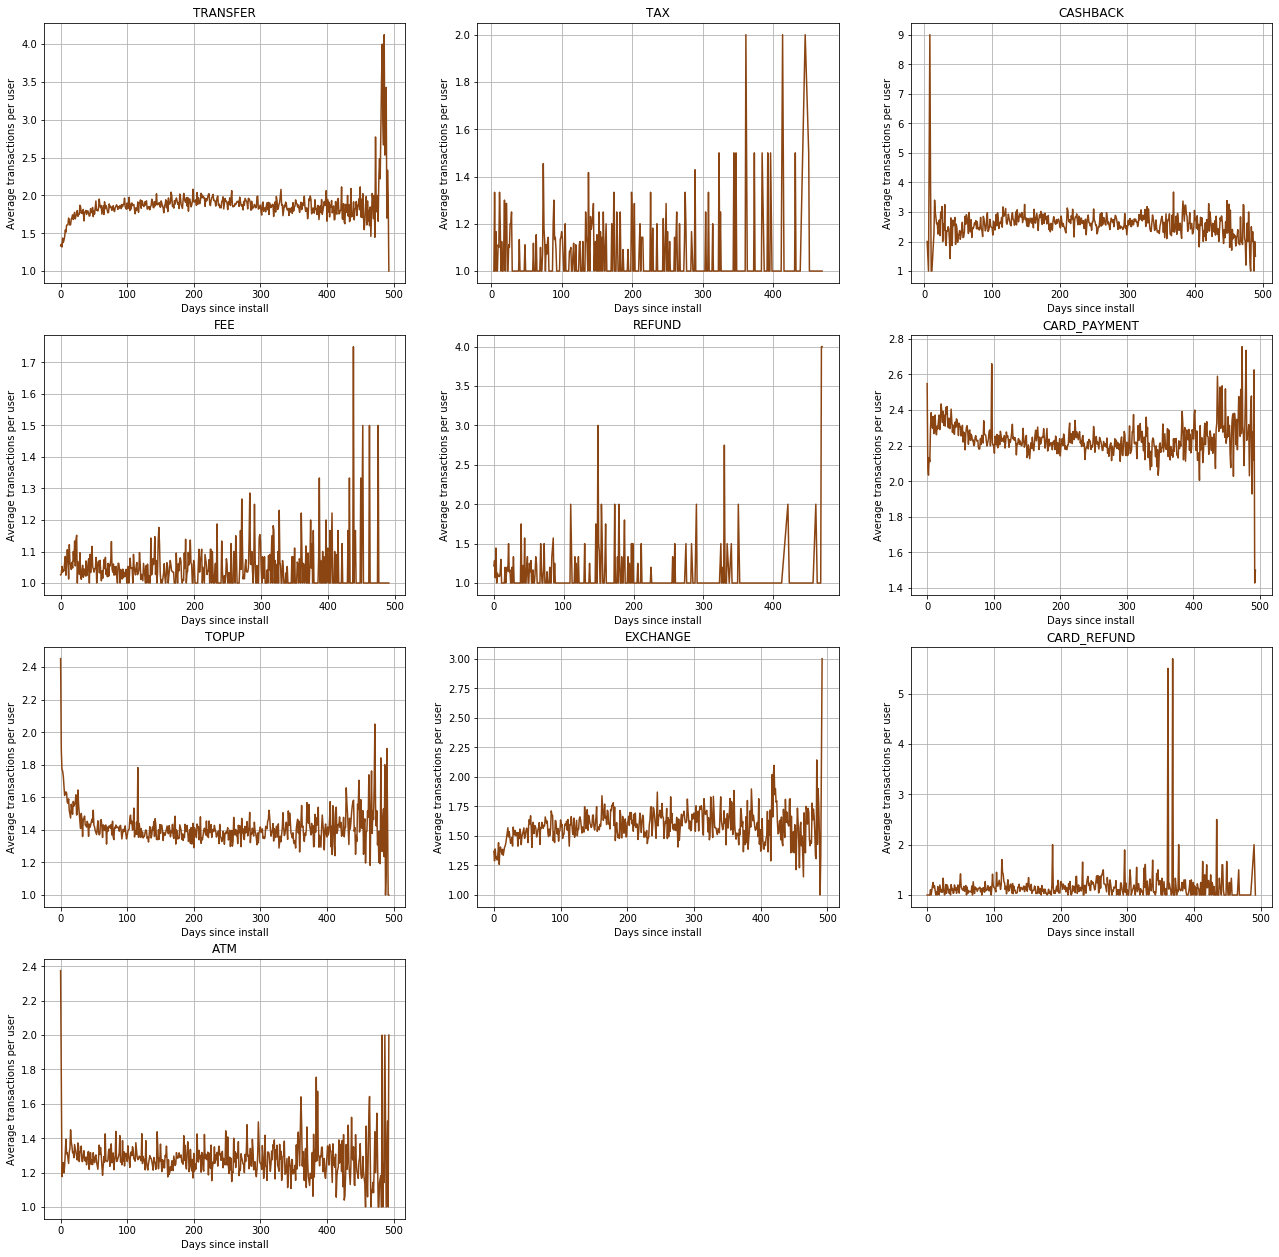

In [30]:
# Ploting every transaction type 
plt.figure(figsize=(22, 22))
for i, txn_type in enumerate(list(set(d_install['transactions_type']))):
    subd = d_install[d_install['transactions_type']==txn_type]
    plt.subplot(4, 3, i + 1)
    plt.plot('days_since_account_creation', 'avg_transactions', data=subd, color='saddlebrown')
    plt.title(txn_type)
    plt.xlabel('Days since install')
    plt.ylabel('Average transactions per user')
    plt.grid()
plt.show()

The above graphs show the average transactions per user every day since installation by every transaction type. As we can see, the three biggest types - **CARD_PAYMENT**, **TRANSFER** and **TOPUP** stay around the mean and do not have a big downwards trend. This means that the users, on average, transact the same number of times daily during the whole period that they are with revolut.

## Empirical cumulative distribution function (ECDF)

Before analyzing the distribution of users by the time since their last transaction we need to introduce the **empirical cumulative distribution function** (or **ecdf** for short). 

The definition of that function is as follows:

Given an empirical sample ($x_{1}$, $x_{2}$, ..., $x_{n}$) of a random variable $X$ the empirical cumulative distribution functions is defined by 

$$ F(t) = \dfrac{\# x_{i} \leq t}{n} = \dfrac{1}{n} \sum_{i}^{n} 1_{x_{i} \leq t} $$

where $1_{A}$ is the indicator of an event $A$.

In other words, **for a given t (most commonly called a treshold), the function gives a share of the total values in the sample that are less than or equal to t.** 

For example, F(**200**) = **0.8** would mean that in the observed sample, **80 percent** of all observations or less than or equal to **200**. 

The function values range from 0 to 1 and the function is an increasing function. 

## Time since last transaction 

We need to analyze how many users transact after n days since their last transactions. If a user is engaged, then he transacts or in any other way uses the application on a regular basis. The number of users that transact after n days after last transaction should be less then or equal to the number of users that transacted after n-1 days.

We will analyze the ecdf plots to determine the distribution of users that transacted after n days of inactivity.

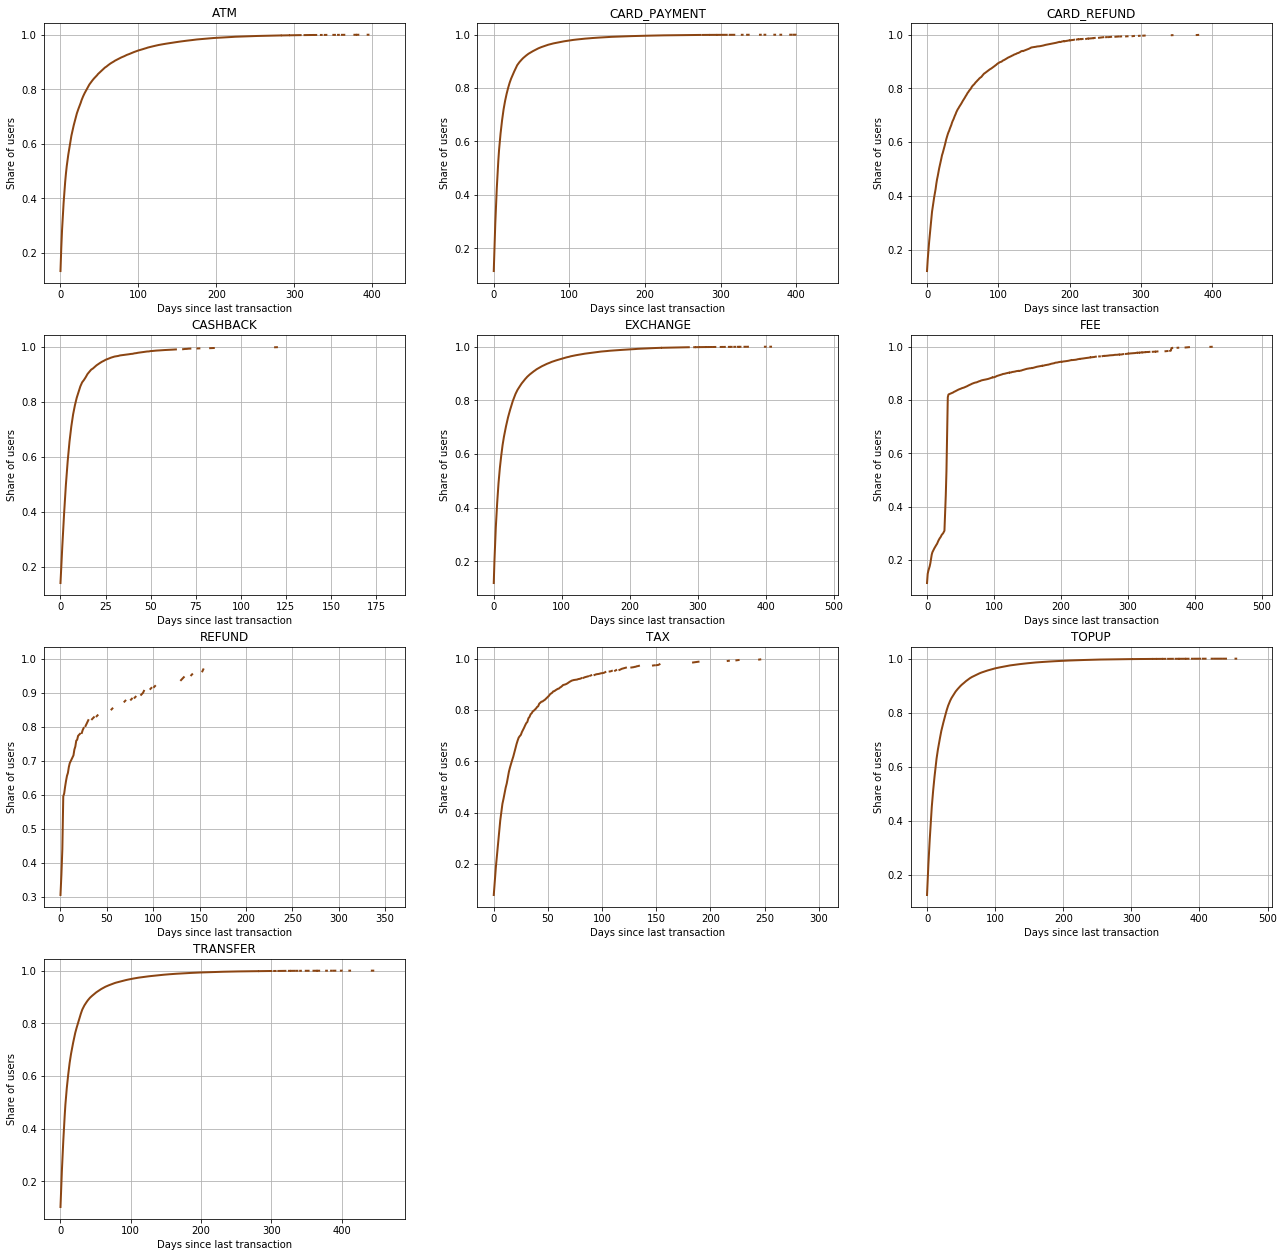

In [31]:
# Calculating the difference in time between transactions
d.sort_values(['user_id', 'transactions_type', 'transaction_date'], inplace=True)
grouped = d.groupby(['user_id', 'transactions_type'], as_index=False)['transaction_date'].diff()
d['time_since_last_txn'] = [x.days for x in grouped.reset_index()['transaction_date']]

# Counting the number of unique users that transact after n days of previous transaction
grouped = d.dropna().groupby(['transactions_type', 'time_since_last_txn'], as_index=False).apply(lambda x: len(set(x['user_id'])))

# Creating a tidy data frame 
df = grouped.index.to_frame()
df['number_of_users'] = grouped
df = df.rename(columns={'transactions_type': 'type', 'time_since_last_txn': 'days_since_last_transaction'})

# Pivoting the table 
df = df.pivot_table(index='days_since_last_transaction', columns='type', values='number_of_users')

# Calculating the share of total users
df = df.apply(lambda x: x/np.sum(x))

# Calculating the cumulative sums of shares to get ECDF data
df = df.apply(lambda x: x.cumsum())

# Ploting the ECDF data
plt.figure(figsize=(22, 22))
for i, txn_type in enumerate(df.columns):
    plt.subplot(4, 3, i + 1)
    plt.plot(df.index, df[txn_type], color='saddlebrown', linewidth=2)
    plt.title(txn_type)
    plt.xlabel('Days since last transaction')
    plt.ylabel('Share of users')
    plt.grid()
plt.show()

On the x axis we have the number of days since last transaction, and on the y axis we have the share of total users. The empirical cumulative distribution function values represent the share of users that transacted after x days or less. 

For example, we can see that for CARD_PAYMENT, the percentage of users that transacted after 100 days since their last transaction **or less** is very near 100 percent. This means, that there are very few users that transacted after 100 days **or more** of inactivity.

In [32]:
df[df.index==90]

type,ATM,CARD_PAYMENT,CARD_REFUND,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER
days_since_last_transaction,,,,,,,,,,
90.0,0.93151,0.973838,0.874103,NaN,0.947321,0.87845,0.905172,0.935273,0.95701,0.962088


The table above shows the percentage of users who transact after **90 days or less** since their last transaction. To get the share of users that transacted after 90 days since their last transaction we need to subtract the values in the table from 1. For example, for the biggest type CARD_PAYMENT, the share of users that still transacted after 90 days of inactivity is about 0.025 or 2.5 percent.

## Disengaged user definition

From the ecdf plots and the table in the previous section we can define a disengaged user:

**A user is considered disengaged if a user does not make any transactions after 90 days from his last transaction.** 

# Modeling the disengaged users

In this section we will try to create a model to determine whether a user is disengaged or not. If we would calculate the difference between current day and the last transactions' date, we would get that all the users are disengaged. This is because we are working with a snaphost of data from the database. 

We know that the last user signed in on 2019-01-03. We will only keep that users that signed in prior to 2019-01-03 minus 90 days. This is because we want to create a model with enough time for all the users to show that they are disengaged or not.

I will assume that the current date is 2019-01-03.

## Logistic regression model

I will use the logistic regression model to predict whether a user is engaged or not. I use logistic regression for several reasons: 

1. Our objective is to classify whether a user is engaged or not. This means that this is a clasical binary classification problem which logistic regression works well in solving.

2. Logistic regression outputs probabilities for each user so we can analyze how confident we are that a user is disengaged or not. Additionally, we can change the treshold from 0.5 to any value in determining whether a user is disengaged or not.

3. Logistic regression is implemented in python in the skicit-learn package with minimal amount of hyper parameters. 

4. The fitting of the model is fast and reliable.

5. We can analyze the coefficients near the features to determine which features are most important, whether the results are logical, which features lead to a user beeing disengaged and which features indicate that a user is engaged.

The logistic regression model for a binary random variable is defined by the equation:

$$P(Y=1|X)=\dfrac{1}{1 + e^{-\beta_{0} - \beta_{1}X_{1} - ... - \beta_{p}X_{p}}}$$

Given the data of $(Y, X)$, a solver in the computer tries to find the best coefficients $\beta_{i}$ that for each $y_{i} = 1$ the term $\dfrac{1}{1 + e^{-\beta_{0} - \beta_{1}X_{1i} - ... - \beta_{p}X_{pi}}}$ has a high value and for each $y_{i} = 0$ the same term has a low value.

This process is often called the maximum likelihood estimation.

The function $f(z) = \dfrac{1}{1 + e^{z}}$ has the range of $(0, 1)$ so we can loosely interpret the values of that function as probabilities. A 'high' value of the classifier would mean the probability beeing in the range of [0.7, 1), and a low value indicating that the probability is in the range of (0, 0.3].

## Hyper parameters for logisitic regression

To read more about all the possible hyper parameters for the logistic regression visit: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html.

We will mainly use the default parameters except the ones bellow:

In [48]:
hyper_params = {
    'solver': 'lbfgs', # you have to define the solver in the skicit learn implementation
    'max_iter': 1000 # expanding the default number of iterations for the solver 
}

## Creating the X and Y matrices 

The main idea when creating the X and Y matrices is to have **one row for one unique user**. Thus every created feature will be an aggregation on the user_id level.

In [33]:
# Defining the 'current' date
current_date = datetime.datetime(2019, 1, 3) 

# Subseting the users
usr = users[users['account_created_date'] < datetime.datetime(2019, 1, 3) - datetime.timedelta(days=90)]

# Getting the last transaction
d = pd.merge(transactions, usr, on='user_id').groupby(['user_id'], as_index=False)['created_date'].max()
d = d.rename(columns={'created_date': 'last_transaction_date'})

# Assigning the 'current' date 
d['current_date'] = current_date

# Getting the differences between the the current date and the last transaction date
d['days_since_last_transaction'] = [x.days for x in d['current_date'] - d['last_transaction_date']]

# Creating the label for disengaged users
d['is_disengaged'] = [1 if x > 90 else 0 for x in d['days_since_last_transaction']]

# Leaving only the necessary information 
d = d[['user_id', 'is_disengaged']]

The distribution of classes: 

In [34]:
class_distribution = d.groupby('is_disengaged', as_index=False).count().rename(columns={'user_id': 'user_count'})
class_distribution['share_of_total'] = class_distribution['user_count']/np.sum(class_distribution['user_count'])
class_distribution

,is_disengaged,user_count,share_of_total
0,0,11151,0.850637
1,1,1958,0.149363


As it turns out, about 15 percent of the users in the dataset sent the last transaction more than 90 days ago when compared to the 'current' date. This means that there are 15 percent of disengaged users in our dataset. 

In [35]:
# Getting aggregated user level information from transactions
txn = pd.merge(transactions, usr, on='user_id').copy()

# Extracting the features from the transactions 
fe = TransactionFeatures(txn)
txn_ft = fe.feature_engineering_pipeline()

# Merging all the feature infromation to the labeled user data 

# User info
dt = pd.merge(d, users[['user_id', 'country', 'birth_year', 'plan']], on='user_id')

# Device info
dt = pd.merge(dt, devices, on='user_id')

# Extracted information from transaction data 
dt = pd.merge(dt, txn_ft, on='user_id')

# Droping the user_id column because it has no use here anymore 
dt.drop('user_id', axis=1, inplace=True)

# Shuffling the data for the k fold analysis
dt = dt.sample(frac=1)

# Creating the dummy variables 
dt = pd.get_dummies(dt)

# Droping NA 
dt.dropna(inplace=True)
dt.reset_index(inplace=True, drop=True)

# Spliting into Y and X matrix 
Y, X = dt['is_disengaged'], dt.drop('is_disengaged', axis=1)

In [44]:
# Shape of the design matrix
X.shape

(13109, 65)

After all the subseting we have 13109 rows representing unique users and 65 columns representing different features.

In [46]:
# Shape of the dependent variable
Y.shape

(13109,)

In [45]:
# Feature list
X.columns

Index(['birth_year', 'amount_usd', 'avg_txn', 'ATM', 'CARD_PAYMENT',
       'CARD_REFUND', 'CASHBACK', 'EXCHANGE', 'FEE', 'REFUND', 'TAX', 'TOPUP',
       'TRANSFER', 'INBOUND', 'OUTBOUND', 'country_AT', 'country_AU',
       'country_BE', 'country_BG', 'country_CH', 'country_CY', 'country_CZ',
       'country_DE', 'country_DK', 'country_EE', 'country_ES', 'country_FI',
       'country_FR', 'country_GB', 'country_GF', 'country_GG', 'country_GI',
       'country_GP', 'country_GR', 'country_HR', 'country_HU', 'country_IE',
       'country_IM', 'country_IS', 'country_IT', 'country_JE', 'country_LI',
       'country_LT', 'country_LU', 'country_LV', 'country_MQ', 'country_MT',
       'country_NL', 'country_NO', 'country_PL', 'country_PT', 'country_RE',
       'country_RO', 'country_SE', 'country_SI', 'country_SK', 'plan_METAL',
       'plan_METAL_FREE', 'plan_PREMIUM', 'plan_PREMIUM_FREE',
       'plan_PREMIUM_OFFER', 'plan_STANDARD', 'brand_Android', 'brand_Apple',
       'brand_Unknown'],


## Feature explanation

Every feature is calculated per user. Feature description:
    
**birt_year** - an integer regarding the birth year of a user. 

**amount_usd** - average amount of transaction in usd.

**avg_txn** - average daily transaction count.

--

**ATM** - share of all transactions that were the ATM type.

**CARD_PAYMENT** - share of all transactions that were the CARD_PAYMENT type.

**CARD_REFUND** - share of all transactions that were the CARD_REFUND type.

**CASHBACK** - share of all transactions that were the CASHBACK type.

**EXCHANGE** - share of all transactions that were the EXCHANGE type. 

**FEE** - share of all transactions that were the FEE type. 

**REFUND** - share of all transactions that were the REFUND type.

**TAX** - share of all transactions that were the TAX type.

**TOPUP** - share of all transactions that were the TOPUP type. 

**TRANSFER** - share of all transactions that were the TRANSFER type.

--

**INBOUND** - share of all transactions that the direction feature equal to INBOUND.

**OUTBOUND** - share of all transactions that the direction feature equal to OUTBOUND.

--

**country_x** - dummy variable for country x.

**plan_x** - dummy variable for plan x.

**brand_x** - dummy variable for brand x.

## K fold analysis 

I will do a 5 fold evaluation of the logistic regression model. In each fold, 20 percent of the data is used as test data for accuracy measurments and 80 percent of the data is used to train the model. 

In [50]:
kfold = KFold(n_splits=5)
acc = []
number_of_disengaged = []
real_number_of_disengaged = []

for train_index, test_index in kfold.split(X):
    X_fold = X.loc[train_index]
    Y_fold = Y.loc[train_index]
    
    # Clasifier creation
    clf = LogisticRegression(**hyper_params).fit(X_fold, Y_fold)
    
    # Forecasts
    y_hat = clf.predict(X.loc[test_index])
    acc.append(accuracy_score(Y.loc[test_index], y_hat))
    
    # Number of disengaged users found
    number_of_disengaged.append(np.sum(y_hat==1))
    
    # Number of real disengaged users
    real_number_of_disengaged.append(np.sum(Y.loc[test_index]==1))

The accuracy scores of each fold is as follows: 

In [51]:
[round(x, 3) for x in acc]

[0.884, 0.895, 0.893, 0.882, 0.892]

Depending on the fold, **the accuracy of the clasifier is from 88 to 89 percent**. This means that out of all the predicted disengaged users, 88 to 89 percent of them will trully be disengaged. 

The number of disengaged users found in each fold:

In [39]:
number_of_disengaged

[237, 222, 243, 249, 217]

The real number of disengaged users in each fold:

In [40]:
real_number_of_disengaged

[419, 386, 384, 411, 358]

As we can see, the classifier misses just bellow half of all trully disengaged users. This can be improved with more features, more data and/or changing the classifier.

## Model fitting on all data and feature importance analysis

We will fit the logistic regression model on all the data and analyze the coefficient values near the features. A high coefficient value indicates that high values in the feature associated with the coefficient increases the probability for a user beeing disengaged P(class = 1). A low value of a coefficient means that high values in the associated feature increases the probability for a user beeing engaged P(class = 0) = 1 - P(class = 1).

In [53]:
# Fitting the model 
model = LogisticRegression(**hyper_params).fit(X, Y)

# Constructing feature importance dataframe
df_ft = pd.DataFrame({
    'feature': X.columns.tolist(),
    'coef': model.coef_[0]
}).sort_values('coef', ascending=False).reset_index(drop=True)

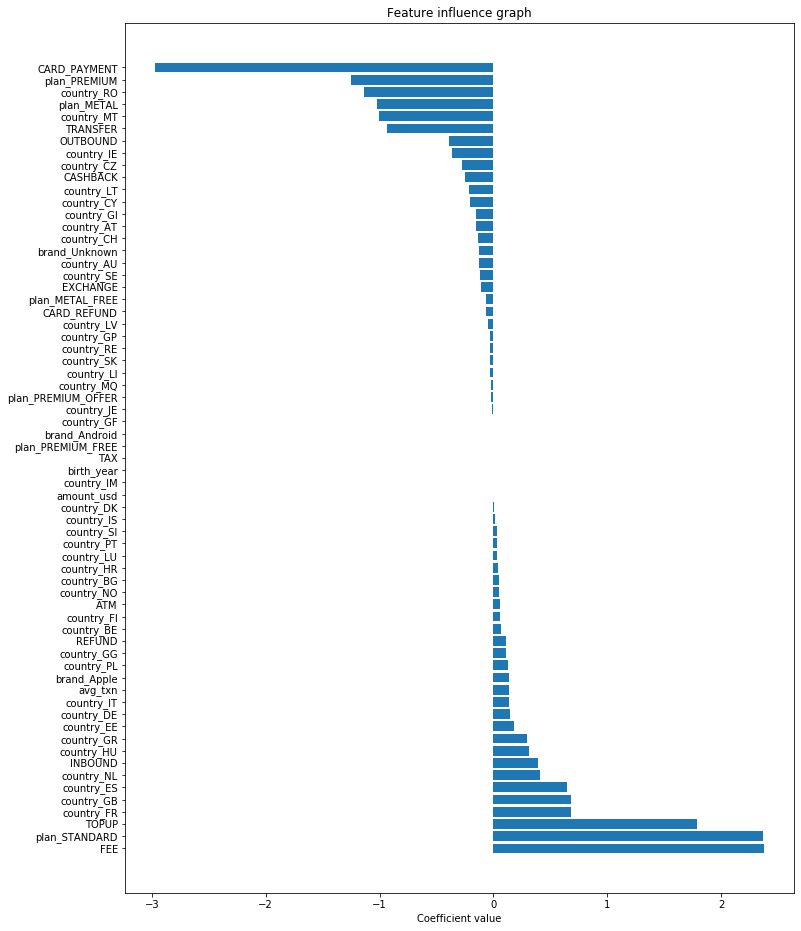

In [54]:
# Ploting the coefficient influence graph
plt.figure(figsize=(12, 16))

# Ploting the distribution by sign in age
plt.barh(y=df_ft['feature'], width=df_ft['coef'])
plt.title('Feature influence graph')
plt.xlabel('Coefficient value')
plt.show()

The top feature interpretation defining an **engaged** user:

* Bigger number of transactions that have the CARD_PAYMENT or TRANSFER types lead to users beeing engaged.  

* Users with PREMIUM or METAL plans tend to be more engaged that with other plans. 

* Users from RO or MT countries tend to be more engaged on average. 

* On average, bigger number of OUTBOUND direction transactions lead to users beeing engaged when compared to the INBOUND direction.

The top feature interpretation defining an **disengaged** user:

* If the users send mostly FEE or TOPUP transactions it leads to them beeing disengaged.

* Having the STANDART plan increases the chances of beeing disengaged. 

* On average, bigger number of INBOUND direction transactions lead to users beeing disengaged when compared to the OUTBOUND direction.

From the EDA of the transactions data set, it is clear that most users use STANDART plan and use the CARD_PAYMENT types. This means, that for most users, these two features cancel each other out when calculating the probability whether they are disengaged or not. 

The more informative features are the TOPUP, FEE, plan_PREMIUM and plan_METAL features when deciding user engagement.